In [37]:
import pandas as pd
import dask.dataframe as dd
from dask.multiprocessing import get

import itertools
pd.set_option('display.max_rows', 700)
pd.set_option('display.max_columns', 600)

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, svm, tree
from sklearn.ensemble import RandomForestRegressor
from  sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
sns.set(rc={'figure.figsize':(16,9)})
#import swifter

np.random.seed(1907)

In [38]:
def initial_data_preparation():
    

    data = pd.read_csv("../data/interim/spark_processed_data.csv", sep="|")

    
    
    print(f"{len(data)} Rows.")
   

    multi_choice_columns = pd.read_csv("../data/interim/spark_multi_choice_columns.csv", sep="|")["0"].tolist()
    data = data.drop(multi_choice_columns, axis=1)
    
    #Outlier Handling
    # Age 90'dan büyükse sil
    data = data[data["Age"] <90]
    # WorkWeekHrs drop
    data = data.drop("WorkWeekHrs", axis=1)
    

    
    # Preserve country columns for target transformation
    data["Country_for_target_transformation"] = data["Country"]
    
    #Drop observations have less then $100 ConvertedComp and professional dev.
    data = data[data["ConvertedComp"]>100]

    #Drop observations have greater then $0.5M ConvertedComp
    data = data[data["ConvertedComp"]<=500000]
    
    #Use the data only from professional developers
    data = data[data.MainBranch == "I am a developer by profession"]
    
    # One hot encoding
    cat_columns = ["Country", "Gender", "JobSat", 
                                        "JobSeek",
                                        "Employment",
                                        "MainBranch", 
                                        "Hobbyist", 
                                        "EdLevel", 
                                        "NEWDevOps", 
                                        "NEWDevOpsImpt", 
                                        "NEWEdImpt", 
                                        "NEWLearn",
                                        "NEWOffTopic",
                                        "NEWOnboardGood",
                                        "NEWOtherComms",
                                        "NEWOvertime",
                                        "NEWPurpleLink","OpSys","OrgSize",
                                        "PurchaseWhat","SOAccount",
                                        "SOComm","SOPartFreq","SOVisitFreq",
                                        "SurveyEase", "SurveyLength","Trans", "UndergradMajor","WelcomeChange"]
    
    cat_columns = [col for col in cat_columns if col not in multi_choice_columns]
    data = pd.get_dummies(data=data, columns=cat_columns)

    
    data = data.dropna(subset=["ConvertedComp"], axis=0)
    data = data[data["ConvertedComp"] >0]
    
    #Drop countries that has less than 150 observation
    countries = data["Country_for_target_transformation"].value_counts()
    countries_to_drop = countries[countries <= 200].index.tolist()
    data = data[~data["Country_for_target_transformation"].isin(countries_to_drop)].reset_index(drop=True)
    
    
    print(f"{len(data)} Rows.")
    
    
    # Fill NaNs with median
    nas = data.isna().sum()
    nas = nas[nas > 0]

    for na_col in nas.index:
        data[na_col].fillna(data[na_col].median(), inplace=True)

    #LABEL :"ConvertedComp"
    return data

In [39]:
def load_processed_data(force_processing=False):
    if force_processing:
        data = initial_data_preparation()
        data.to_csv("../data/processed/processed_data.csv", sep="|", index=False)
    else:
        try:
            data = pd.read_csv("../data/processed/processed_data.csv", sep="|")
        except Exception as e:
            print(e)
            data = initial_data_preparation()
            data.to_csv("../data/processed/processed_data.csv", sep="|", index=False)
    
    return data

data = load_processed_data(force_processing=False)

In [40]:
data.head().columns
#PRESENTATION

Index(['Age', 'Age1stCode', 'ConvertedComp', 'YearsCode', 'YearsCodePro',
       'DatabaseDesireNextYear_MariaDB',
       'DatabaseDesireNextYear_Microsoft SQL Server',
       'DatabaseDesireNextYear_MongoDB', 'DatabaseDesireNextYear_MySQL',
       'DatabaseDesireNextYear_Oracle',
       ...
       'UndergradMajor_I never declared a major',
       'UndergradMajor_Information systems, information technology, or system administration',
       'UndergradMajor_Mathematics or statistics',
       'UndergradMajor_Web development or web design',
       'WelcomeChange_A lot less welcome now than last year',
       'WelcomeChange_A lot more welcome now than last year',
       'WelcomeChange_Just as welcome now as I felt last year',
       'WelcomeChange_Not applicable - I did not use Stack Overflow last year',
       'WelcomeChange_Somewhat less welcome now than last year',
       'WelcomeChange_Somewhat more welcome now than last year'],
      dtype='object', length=569)

In [41]:
a = pd.read_csv("../data/raw/survey_results_public.csv")


In [42]:
a.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Ethnicity,Gender,JobFactors,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWJobHunt,NEWJobHuntResearch,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurchaseResearch,NEWPurpleLink,NEWSOSites,NEWStuck,OpSys,OrgSize,PlatformDesireNextYear,PlatformWorkedWith,PurchaseWhat,Sexuality,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,EUR,Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",White or of European descent,Man,"Languages, frameworks, and other technologies ...",Slightly satisfied,I am not interested in new job opportunities,C#;HTML/CSS;JavaScript,C#;HTML/CSS;JavaScript,.NET Core;Xamarin,.NET;.NET Core,Microsoft Teams;Microsoft Azure;Trello,Confluence;Jira;Slack;Microsoft Azure;Trello,No,Somewhat important,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,Often: 1-2 days per week or more,Start a free trial;Ask developers I know/work ...,Amused,Stack Overflow (public Q&A for anyone who codes),Visit Stack Overflow;Go for a walk or other ph...,Windows,2 to 9 employees,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows,NaN,Straight / Heterosexual,No,"No, not at all",NaN,Multiple times per day,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,GBP,NaN,NaN,"Developer, full-stack;Developer, mobile","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,NaN,NaN,NaN,Very dissatisfied,I am not interested in new job opportunities,Python;Swift,JavaScript;Swift,React Native;TensorFlow;Unity 3D,React Native,Github;Slack,Confluence;Jira;Github;Gitlab;Slack,NaN,NaN,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,NaN,NaN,Amused,Stack Overflow (public Q&A for anyone who code...,Visit Stack Overflow;Go for a walk or other ph...,MacOS,"1,000 to 4,999 employees",iOS;Kubernetes;Linux;MacOS,iOS,I have little or no influence,NaN,Yes,"Yes, definitely",Less than once per month or monthly,Multiple times per day,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Objective-C;Python;Swift,Objective-C;Python;Swift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Once a decade,NaN,NaN,No,NaN,NaN,NaN,Stack Overflow (public Q&A for anyone who codes),NaN,Linux-based,NaN,NaN,NaN,NaN,NaN,Yes,"Yes, somewhat",A few times per month or weekly,Daily or almost daily,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,ALL,NaN,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,White or of European descent,Man,Flex time or a flexible schedule;Office enviro...,Slightly dissatisfied,"I’m not actively looking, but I am open to new...",NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,Not at all important/not necessary,Curious about other opportunities;Wanting to w...,NaN,Once a year,Not sure,Yes,Yes,Occasionally: 1-2 days per quarter but less th...,NaN,NaN,Stack Overflow (public Q&A for anyone who code...,NaN,Lin

In [43]:
a.head()[["Respondent", "LanguageWorkedWith"]]

,Respondent,LanguageWorkedWith
0,1,C#;HTML/CSS;JavaScript
1,2,JavaScript;Swift
2,3,Objective-C;Python;Swift
3,4,NaN
4,5,HTML/CSS;Ruby;SQL


## TODO

- Dev Type'a göre en çok kullanılan teknolojiler ve herkes bunlardan ne kadarını biliyor. **Erdem**
- Sunum Hazırlama **Bengi**
- Rapor **Berk**

In [44]:
def target_transformation(x_train, x_test, y_train, y_test):
    train_set = pd.concat([x_train, y_train], axis=1)
    test_set = pd.concat([x_test, y_test], axis=1)
    
    avg_prf_comp_by_country = train_set.groupby("Country_for_target_transformation").ConvertedComp.median()
    target_transformer = lambda row: (row['ConvertedComp'] / avg_prf_comp_by_country[row["Country_for_target_transformation"]]) *100
    
    y_train = train_set.apply(target_transformer, axis=1 ).rename("ConvertedComp_index")
    y_test = test_set.apply(target_transformer, axis=1 ).rename("ConvertedComp_index")
    
    y_train = np.log10(y_train)
    y_test = np.log10(y_test)
    
    inverse_target_transformer = lambda row: (avg_prf_comp_by_country[row["Country_for_target_transformation"]]) / 100
    
    inverse_multiplier_y_train = train_set.apply(inverse_target_transformer, axis=1 ).rename("ConvertedComp_index_inverse")
    inverse_multiplier_y_test = test_set.apply(inverse_target_transformer, axis=1 ).rename("ConvertedComp_index_inverse")
    
    return x_train, x_test, y_train, y_test, inverse_multiplier_y_train, inverse_multiplier_y_test
#PRESENTATION

In [45]:
def calculate_high_and_low_leverage_tech(data):
            technologies = [feat for feat in data.columns if "WorkedWith" in feat]
            us_data = data[data["Country_for_target_transformation"] =="United States"]
            tech_leverages = {}
            for tech in technologies:
                tech_median = us_data.groupby(tech).ConvertedComp.median()
                if len(tech_median) != 2: continue
                tech_leverage = (tech_median.loc[1] / tech_median.loc[0]) -1
                tech_leverages[tech] = tech_leverage
            tech_leverages = pd.Series(tech_leverages).sort_values(ascending=False)

            high_leverage_technologies = tech_leverages[tech_leverages >= tech_leverages.quantile(0.80)].index.tolist()
            low_leverage_technologies = tech_leverages[tech_leverages <= tech_leverages.quantile(0.20)].index.tolist()
            return high_leverage_technologies, low_leverage_technologies

In [46]:
def prepare_data(data=data, 
                 exclude_columns=None, 
                 features_to_use=None, 
                 apply_x_col=None, 
                 columns_to_bin=None,
                 transform_target=False,
                 feat_agg_calculate_chosen_options_ratio=False,
                 feat_agg_worked_with_high_and_low_leverage=False,
                 feat_agg_worked_with_relevant_tech=False):

    
    if exclude_columns is not None and features_to_use is not None:
        raise Exception("exclude_columns and features_to_use cannot be used at the same time.")

    if exclude_columns is not None:
        data = data.drop(exclude_columns, axis=1)

    if features_to_use is not None:
        pass
        
    #PRESENTATION
    if feat_agg_calculate_chosen_options_ratio:
        def proportion_chosen_options(columns_contains):
            desire_next_year_feats = [feat for feat in data.columns if columns_contains in feat]
            return data[desire_next_year_feats].sum(axis=1) / len(desire_next_year_feats)
        
        data["feat_agg_proportion_chosen_DesireNextYear"] = proportion_chosen_options("DesireNextYear")
        data["feat_agg_proportion_chosen_LanguageDesireNextYear"] = proportion_chosen_options("LanguageDesireNextYear")
        data["feat_agg_proportion_chosen_PlatformDesireNextYear"] = proportion_chosen_options("PlatformDesireNextYear")
        data["feat_agg_proportion_chosen_WebframeDesireNextYear"] = proportion_chosen_options("WebframeDesireNextYear")
        data["feat_agg_proportion_chosen_DatabaseDesireNextYear"] = proportion_chosen_options("DatabaseDesireNextYear")

        data["feat_agg_proportion_chosen_WorkedWith"] = proportion_chosen_options("WorkedWith")
        data["feat_agg_proportion_chosen_LanguageWorkedWith"] = proportion_chosen_options("LanguageWorkedWith")
        data["feat_agg_proportion_chosen_PlatformWorkedWith"] = proportion_chosen_options("PlatformWorkedWith")
        data["feat_agg_proportion_chosen_WebframeWorkedWith"] = proportion_chosen_options("WebframeWorkedWith")
        data["feat_agg_proportion_chosen_DatabaseWorkedWith"] = proportion_chosen_options("DatabaseWorkedWith")
        
        

    x = data.drop('ConvertedComp', axis=1)
    
    y = data['ConvertedComp']

    if apply_x_col is not None:
        x = x.apply(apply_x_col)
    

    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size = 0.33, 
                                                        random_state = 3, 
                                                        stratify=x["Country_for_target_transformation"])

    # Outlier handling
    # Age 70'den büyükse 70 
    x_train["Age"] = x_train["Age"].mask(x_train["Age"] > 70, 70)
    # YearsCodePro & YearsCode 40'dan büyükse 40
    x_train["YearsCodePro"] = x_train["YearsCodePro"].mask(x_train["YearsCodePro"] > 40, 40)
    x_train["YearsCode"] = x_train["YearsCode"].mask(x_train["YearsCode"] > 40, 40)
    # Age1stCode 30 üzeriyse 30
    x_train["Age1stCode"] = x_train["Age1stCode"].mask(x_train["Age1stCode"] > 30, 30)
    
    #PRESENTATION
    if feat_agg_worked_with_relevant_tech:  
        usage_ratios = pd.read_csv("../data/interim/tech_groups_by_dev_type.csv", sep="|")
        dev_types = [col for col in data.columns if "DevType_" in col]

        def proportion_chosen_given_Tech(technologies):
            return data[technologies].sum(axis=1) / len(technologies)

                    
        for dev_type in dev_types:
            relevant_tech = usage_ratios[usage_ratios.dev_type==dev_type].tech.tolist()
            
            x_train[f"feat_agg_proportion_worked_with_{dev_type}_tech"] = proportion_chosen_given_Tech(relevant_tech)
            x_test[f"feat_agg_proportion_worked_with__{dev_type}__tech"] = proportion_chosen_given_Tech(relevant_tech)

    
    
    #PRESENTATION
    if feat_agg_worked_with_high_and_low_leverage:
        high_leverage_technologies, low_leverage_technologies = calculate_high_and_low_leverage_tech(pd.concat([x_train, y_train], 
                                                                                                               axis=1))
        def proportion_chosen_given_Tech(technologies):
            return data[technologies].sum(axis=1) / len(technologies)
        
        x_train["feat_agg_high_leverage_tech_worked"] = proportion_chosen_given_Tech(high_leverage_technologies)
        x_train["feat_agg_low_leverage_tech_worked"] = proportion_chosen_given_Tech(low_leverage_technologies)
        
        
        x_test["feat_agg_high_leverage_tech_worked"] = proportion_chosen_given_Tech(high_leverage_technologies)
        x_test["feat_agg_low_leverage_tech_worked"] = proportion_chosen_given_Tech(low_leverage_technologies)
        
        technologies = [feat for feat in data.columns if (("WorkedWith" in feat) or ("DesireNextYear" in feat))]
        x_train = x_train.drop(technologies, axis=1)
        x_test = x_test.drop(technologies, axis=1)
    
    
    if transform_target:
        x_train, x_test, y_train, y_test, inverse_multiplier_y_train, inverse_multiplier_y_test = target_transformation(x_train, x_test, y_train, y_test)
        print("Target Transformed")
    else:
        inverse_multiplier_y_train, inverse_multiplier_y_test = None, None
    
    #Preserved from initial data preparation for target_transformation
    x_train.drop(["Country_for_target_transformation"], axis=1, inplace=True)
    x_test.drop(["Country_for_target_transformation"], axis=1, inplace=True)
        
    

    if columns_to_bin is not None:
        for column in columns_to_bin:
            if column not in x_train.columns: continue
            x_train.loc[:,column], bins_ = pd.qcut(x_train.loc[:,column], q=10,  retbins=True, duplicates="drop")
            x_test.loc[:,column] = pd.cut(x_test.loc[:,column], bins=bins_, )
            
            x_train = pd.get_dummies(x_train)
            x_test = pd.get_dummies(x_test)
            
    
    return x_train, x_test, y_train, y_test, data, inverse_multiplier_y_train, inverse_multiplier_y_test

In [47]:
def scale_data(x_train, x_test, scaler=StandardScaler):

    scaler = scaler()
    scaler.fit(x_train)

    x_train_scaled = scaler.transform(x_train)
    x_train_scaled = pd.DataFrame(x_train_scaled, index=x_train.index, columns=x_train.columns)

    x_test_scaled = scaler.transform(x_test)
    x_test_scaled = pd.DataFrame(x_test_scaled, index=x_test.index, columns=x_test.columns)
    
    return x_train_scaled, x_test_scaled

In [48]:
def evaluate_regression(y_true_train, y_pred_train, y_true_test, y_pred_test, 
                        model_name="", 
                        model=None, 
                        num_feat="", 
                        feat=None, 
                        residuals=None,
                        feature_importances=None):
    mape_train = np.abs((y_true_train - y_pred_train) / y_true_train).mean(axis=0)
    mape_test = np.abs((y_true_test - y_pred_test) / y_true_test).mean(axis=0)
    
    mape_ = np.abs((y_true_test - y_pred_test) / y_true_test)
    below_15_prc_mape_ratio = mape_[mape_<=0.15].count() / mape_.count()
    
    return pd.DataFrame.from_records([[#metrics.mean_squared_error(y_true_train, y_pred_train),
                                        mape_train,
                                       metrics.mean_absolute_error(y_true_train, y_pred_train),
                                       metrics.max_error(y_true_train, y_pred_train),
                                       metrics.r2_score(y_true_train, y_pred_train), 
                                      #metrics.mean_squared_error(y_true_test, y_pred_test),
                                        mape_test,
                                        below_15_prc_mape_ratio,
                                       metrics.mean_absolute_error(y_true_test, y_pred_test),
                                       metrics.max_error(y_true_test, y_pred_test),
                                       metrics.r2_score(y_true_test, y_pred_test),
                                       model,
                                       num_feat,
                                         y_true_test, 
                                        y_pred_test,
                                        feat,
                                        residuals,
                                        feature_importances]],
                                     
                                     index=[model_name], 
                                     columns=[#'mean_squared_error_train', 
                                             "mape_train",
                                              'mean_absolute_error_train', 
                                              'max_error_train', 
                                              "r2_score_train",
                                              #'mean_squared_error_test', 
                                             "mape_test",
                                             "below_15_prc_mape_ratio",
                                              'mean_absolute_error_test',
                                              'max_error_test', 
                                              "r2_score_test", 
                                              "model_object", 
                                              "num_feat",
                                             "y_true_test", 
                                             "y_pred_test",
                                            "features", 
                                         "residuals", 
                                         "feature_importances"])


In [49]:
def residual_analysis(x_test, y_test, y_test_pred):
    x_test_ = x_test.copy()
    x_test_["abs_error"] = np.abs(y_test-y_test_pred)
    x_test_["abs_prc_error"] = np.abs((y_test-y_test_pred) / y_test)
    
    x_test_["error"] = y_test-y_test_pred
    x_test_["prc_error"] = (y_test-y_test_pred) / y_test
    
    mae = x_test_["abs_error"].mean()
    mape = x_test_["abs_prc_error"].mean()
    
    residual_data = pd.DataFrame()
    for col in x_test.columns:
        res = x_test_.groupby(col).agg({"abs_error":"mean", "abs_prc_error":"mean", 
                                        "error":"mean", "prc_error":"mean"})
        res["feat"] = res.index.name
        res.index.name = "value"
        res = res.reset_index()
        
        res["abs_error_diff"] = res["abs_error"] / mae
        res["abs_prc_error_diff"] = res["abs_prc_error"] - mape
        
        residual_data = residual_data.append(res)


    return residual_data
#PRESENTATION

In [50]:
def run_models(x_train, x_test, y_train, y_test, 
               feture_elimination_num_feat=None,
              inverse_multiplier_y_train=None, 
             inverse_multiplier_y_test=None):
        results = pd.DataFrame()
        for model in [#linear_model.LinearRegression(), 
                        linear_model.RidgeCV(),
                        linear_model.LassoCV(),
                        svm.LinearSVR(),
                        svm.LinearSVR(C=0.1),
                        svm.LinearSVR(C=10),
                        svm.SVR(kernel="rbf"),
                        #svm.SVR(kernel="poly"),
                        tree.DecisionTreeRegressor(),
                        RandomForestRegressor(n_estimators=500,
                                              n_jobs=-1)
                     ]:
                
                if feture_elimination_num_feat is not None :
                        try:
                                if feture_elimination_num_feat == "auto":
                                        feture_elimination_num_feat = np.linspace(5,len(x_train.columns),5, dtype=int)

                                for n_features_to_select in feture_elimination_num_feat:
                                        model_ = RFE(estimator=model, n_features_to_select=n_features_to_select)
                                        model_.fit(x_train, y_train)
                                        
                                        try:
                                            feature_importances = model_.feature_importances_
                                        except:
                                            feature_importances = None
                                            
                                        
                                        
                                        y_train_pred = model_.predict(x_train)
                                        y_test_pred = model_.predict(x_test)
                                        
                                        if inverse_multiplier_y_train is not None:
                                            y_train_ = (10 ** y_train) * inverse_multiplier_y_train
                                            y_train_pred_ = (10 ** y_train_pred) * inverse_multiplier_y_train
                                            y_test_ = (10 ** y_test) * inverse_multiplier_y_test
                                            y_test_pred_ = (10 ** y_test_pred) * inverse_multiplier_y_test
                                        else:
                                            y_train_ = y_train
                                            y_train_pred_ = y_train_pred
                                            y_test_ = y_test
                                            y_test_pred_ = y_test_pred
                                        
                                        results = results.append(evaluate_regression(y_train_, y_train_pred_, y_test_, y_test_pred_,
                                                                model_name=type(model_).__name__, model=model_, 
                                                                                     num_feat=n_features_to_select,
                                                                                     feat=x_train.columns,
                                                                                     residuals=residual_analysis(x_test, y_test_, y_test_pred_),
                                                                                     feature_importances=feature_importances))
                                return results
                        except Exception as e:
                            print(e)
                                
                        
               
                model.fit(x_train, y_train)
                try:
                    feature_importances = model.feature_importances_
                except:
                    feature_importances = None
                
                
                y_train_pred = model.predict(x_train)
                y_test_pred = model.predict(x_test)
                
                #PRESENTATION
                if inverse_multiplier_y_train is not None:
                    y_train_ = (10 ** y_train) * inverse_multiplier_y_train
                    y_train_pred_ = (10 ** y_train_pred) * inverse_multiplier_y_train
                    y_test_ = (10 ** y_test) * inverse_multiplier_y_test
                    y_test_pred_ = (10 ** y_test_pred) * inverse_multiplier_y_test
                else:
                    y_train_ = y_train
                    y_train_pred_ = y_train_pred
                    y_test_ = y_test
                    y_test_pred_ = y_test_pred

                results = results.append(evaluate_regression(y_train_, y_train_pred_, y_test_, y_test_pred_,
                                                            model_name=type(model).__name__, model=model, 
                                                             num_feat=len(x_train.columns),
                                                             feat=x_train.columns,
                                                            residuals=residual_analysis(x_test, y_test_, y_test_pred_),
                                                            feature_importances=feature_importances
                                                            ))
        return results


In [51]:
experiment_list = pd.DataFrame()

def run(exclude_columns=None, 
        features_to_use=None, 
        name="", 
        apply_x_col=None, 
        x_train_=None, 
        y_train_=None, 
        columns_to_bin=None,
        transform_target=False,
        feture_elimination_num_feat=None,
        feat_agg_calculate_chosen_options_ratio=False,
        feat_agg_worked_with_high_and_low_leverage=False,
       feat_agg_worked_with_relevant_tech=False):
    global experiment_list
    print(name)

    (x_train, x_test, y_train, y_test, data, 
    inverse_multiplier_y_train, inverse_multiplier_y_test) = prepare_data(exclude_columns=exclude_columns, 
                                                        features_to_use=features_to_use, 
                                                        apply_x_col=apply_x_col,
                                                        columns_to_bin=columns_to_bin,
                                                          transform_target=transform_target,
                                                         feat_agg_calculate_chosen_options_ratio=feat_agg_calculate_chosen_options_ratio,
                                                         feat_agg_worked_with_high_and_low_leverage=feat_agg_worked_with_high_and_low_leverage,
                                                         feat_agg_worked_with_relevant_tech=feat_agg_worked_with_relevant_tech)

    if x_train_ is not None or y_train_ is not None:
        x_train, y_train = x_train_, y_train_

    #x_train, x_test = scale_data(x_train, x_test, scaler=StandardScaler)
    
    x_train.fillna(x_train.median(), inplace=True)
    x_test.fillna(x_test.median(), inplace=True)


    results = run_models(x_train, x_test, y_train, y_test, feture_elimination_num_feat=feture_elimination_num_feat,
                        inverse_multiplier_y_train=inverse_multiplier_y_train, 
                         inverse_multiplier_y_test=inverse_multiplier_y_test)

    best_model = (results.sort_values("mape_test")\
                        .reset_index()\
                        .loc[[0], ["mean_absolute_error_train", 
                                   "mape_train",
                                   "mean_absolute_error_test", 
                                   "mape_test",
                                   "index",
                                   "num_feat",
                                   "model_object",
                                   "features", 
                                   "residuals", 
                                   "feature_importances"]]\
                      .rename({0:name, "index":"model_name"}))
    if experiment_list is not None:
        experiment_list = experiment_list.append(best_model)

    return results.sort_values("mape_test")

In [52]:
(x_train, x_test, y_train, y_test, data, 
    inverse_multiplier_y_train, inverse_multiplier_y_test) = prepare_data(transform_target=True,
                                                         feat_agg_calculate_chosen_options_ratio=True,
                                                         feat_agg_worked_with_high_and_low_leverage=True,
                                                         feat_agg_worked_with_relevant_tech=True)

Target Transformed


In [53]:
data.head()[[x for x in data.columns if "LanguageWorkedWith" in x]]

,LanguageWorkedWith_Assembly,LanguageWorkedWith_Bash/Shell/PowerShell,LanguageWorkedWith_C,LanguageWorkedWith_C#,LanguageWorkedWith_C++,LanguageWorkedWith_HTML/CSS,LanguageWorkedWith_JavaScript,LanguageWorkedWith_PHP,LanguageWorkedWith_Python,LanguageWorkedWith_SQL,LanguageWorkedWith_TypeScript,LanguageWorkedWith_VBA,LanguageWorkedWith_R,LanguageWorkedWith_Java,LanguageWorkedWith_Kotlin,LanguageWorkedWith_Scala,LanguageWorkedWith_Swift,LanguageWorkedWith_Ruby,LanguageWorkedWith_Objective-C,LanguageWorkedWith_Dart,LanguageWorkedWith_Go,LanguageWorkedWith_Perl,LanguageWorkedWith_Rust,LanguageWorkedWith_Haskell,LanguageWorkedWith_Julia,feat_agg_proportion_chosen_LanguageWorkedWith
0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.08
1,0,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.24
2,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.20
3,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.16
4,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.24


In [54]:
results = run(exclude_columns=None, name="Initial Run w/o target transformation, binning", transform_target=False)

Initial Run w/o target transformation, binning


In [55]:
results = run(exclude_columns=None, name="Initial Run w/o binning", 
              transform_target=True
              )

Initial Run w/o binning
Target Transformed


In [56]:
results = run(exclude_columns=None, name="Initial Run", transform_target=True,
              columns_to_bin=["Age1stCode", "Age", "YearsCodePro", "YearsCode"])
results

Initial Run
Target Transformed


,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,below_15_prc_mape_ratio,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test,features,residuals,feature_importances
LinearSVR,0.941151,20633.479500,464752.107936,0.483537,0.523697,0.356679,21800.019555,4.654833e+05,0.462590,"LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_i...",613,813 91000.0 21612 52942.0 10322 48...,813 121936.137638 21612 56477.142550 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...,None
SVR,0.502723,14491.161067,428422.605161,0.731574,0.533100,0.340102,22277.760239,4.655621e+05,0.477520,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...",613,813 91000.0 21612 52942.0 10322 48...,813 123488.438038 21612 58764.611686 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...,None
LassoCV,0.886185,21408.257821,464566.363086,0.479425,0.535462,0.346595,22254.459544,4.686054e+05,0.462227,"LassoCV(alphas=None, copy_X=True, cv=None, eps...",613,813 91000.0 21612 52942.0 10322 48...,813 130806.920768 21612 58579.363788 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...,None
RidgeCV,0.845338,21625.527124,466280.070381,0.481341,0.538805,0.336234,22597.683404,4.694103e+05,0.460828,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",613,813 91000.0 21612 52942.0 10322 48...,813 134150.870932 21612 58293.516608 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...,None
LinearSVR,1.097697,28068.274449,477253.158400,0.320610,0.554048,0.247824,28387.474106,4.705871e+05,0.318017,"LinearSVR(C=10, dual=True, epsilon=0.0, fit_in...",613,813 91000.0 21612 52942.0 10322 48...,813 109186.251656 21612 32727.414618 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...,None
LinearSVR,1.045284,21714.640223,463421.645551,0.477774,0.567402,0.340793,22685.007599,4.622576e+05,0.459468,"LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_i...",613,813 91000.0 21612 52942.0 10322 48...,813 127012.968350 21612 57264.754490 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...,None
RandomForestRegressor,0.135730,9248.377658,323176.669002,0.841107,0.594406,0.336649,22782.530861,4.583425e+05,0.459184,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",613,813 91000.0 21612 52942.0 10322 48...,813 142087.618230 21612 94040.822447 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...,"[0.0008431391093380563, 0.0008199723405102126,..."
DecisionTreeRegressor,0.000008,0.498525,116.359706,1.000000,0.984604,0.235944,38069.913496,1.271094e+06,-0.613405,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",613,813 91000.0 21612 52942.0 10322 48...,813 167050.438596 21612 109417.950000 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...,"[0.002085347934799292, 0.0007005675135847027, ..."


In [57]:
results.iloc[0, results.columns.get_loc("residuals")].sort_values("abs_prc_error_diff", ascending=False).head(20)
#PRESENTATION: Stackoverflow'a girmedim diyenlerde hata yüksek.

,value,abs_error,abs_prc_error,error,prc_error,feat,abs_error_diff,abs_prc_error_diff
61,0.633663,6118.985064,7.284506,-6118.985064,-7.284506,feat_agg_proportion_chosen_DesireNextYear,0.280687,6.760809
28,0.277228,25455.924347,6.596799,8950.066699,-6.283087,feat_agg_proportion_chosen_DesireNextYear,1.167702,6.073102
24,0.237624,19412.325028,3.821230,5956.173218,-3.592580,feat_agg_proportion_chosen_WorkedWith,0.890473,3.297532
0,0.000000,14390.614787,2.946331,9693.281111,-2.645733,feat_agg_proportion_chosen_WorkedWith,0.660119,2.422634
61,0.613861,86438.829866,2.857253,71186.818101,-2.226751,feat_agg_proportion_chosen_WorkedWith,3.965080,2.333556
12,0.857143,57966.475989,2.791446,53417.709956,-2.158294,feat_agg_proportion_chosen_DatabaseDesireNextYear,2.659010,2.267749
1,1.000000,21900.290925,2.611643,7228.503230,-2.347358,DevType_Data or business analyst,1.004600,2.087945
1,1.000000,20884.473592,2.121787,9321.650064,-1.871972,MiscTechDesireNextYear_Xamarin,0.958003,1.598090
1,1.000000,21701.477751,2.063163,6892.777875,-1.822471,JobSat_Very dissatisfied,0.995480,1.539466
53,0.524752,53798.233044,2.008796,-42244.084743,-1.851890,feat_agg_proportion_chosen_WorkedWith,2.467807,1.485099


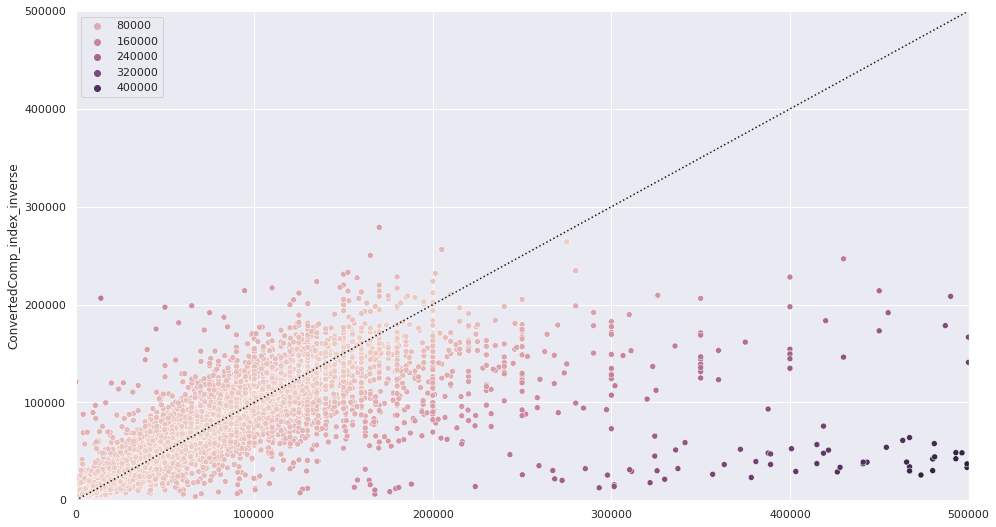

In [58]:
y_true_test = results.iloc[0, results.columns.get_loc("y_true_test")]
y_pred_test = results.iloc[0, results.columns.get_loc("y_pred_test")]

ax = sns.scatterplot( x=y_true_test, y=y_pred_test, hue=np.abs(y_true_test-y_pred_test) )
ax.set(ylim=(0, 500000))
ax.set(xlim=(0, 500000))

x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, ':k')

plt.show()

In [86]:
results = run(exclude_columns=None, name="With Agg Features",
              feat_agg_calculate_chosen_options_ratio=True,
             feat_agg_worked_with_high_and_low_leverage=True,
              columns_to_bin=["Age1stCode", "Age", "YearsCodePro", "YearsCode"],
             transform_target=True)

With Agg Features
Target Transformed


In [99]:
feat_importance = pd.DataFrame(results.loc["RandomForestRegressor", "feature_importances"], 
             index=results.loc["RandomForestRegressor", "features"]).rename({0:"Feature Importance"}, axis=1).sort_values(ascending=False, by="Feature Importance")

In [100]:
feat_importance

,Feature Importance
"YearsCodePro_(0.499, 2.0]",0.106117
feat_agg_high_leverage_tech_worked,0.039889
feat_agg_low_leverage_tech_worked,0.033285
"YearsCodePro_(2.0, 3.0]",0.029723
Employment_Employed part-time,0.024935
Country_India,0.023115
"YearsCodePro_(3.0, 4.0]",0.013954
"OrgSize_10,000 or more employees",0.011452
"Employment_Independent contractor, freelancer, or self-employed",0.009313
"Age_(0.999, 23.0]",0.008920


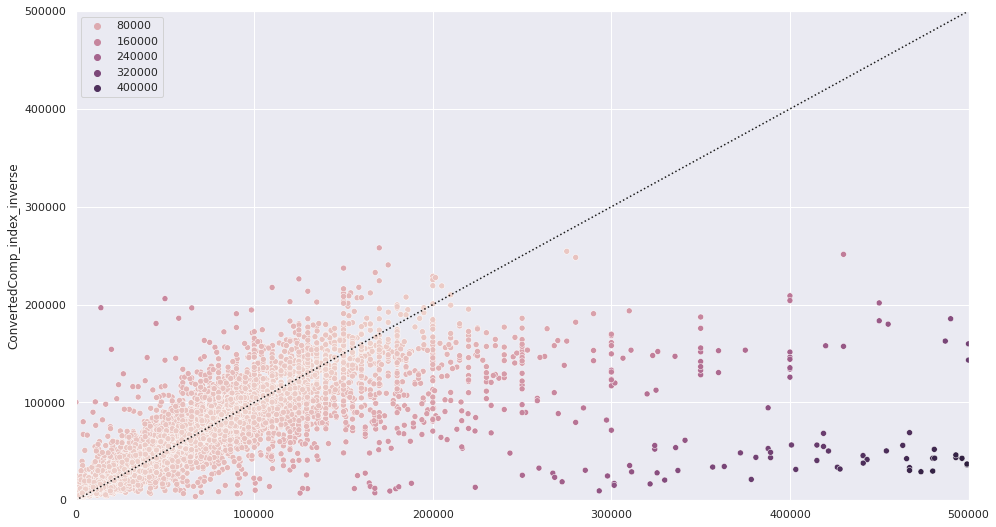

In [61]:
y_true_test = results.iloc[0, results.columns.get_loc("y_true_test")]
y_pred_test = results.iloc[0, results.columns.get_loc("y_pred_test")]

ax = sns.scatterplot( x=y_true_test, y=y_pred_test, hue=np.abs(y_true_test-y_pred_test) )
ax.set(ylim=(0, 500000))
ax.set(xlim=(0, 500000))
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, ':k')
plt.show()

In [62]:
results = run(exclude_columns=None, name="With Agg Features + relevant tech groups",
              feat_agg_calculate_chosen_options_ratio=True,
             feat_agg_worked_with_high_and_low_leverage=True,
              feat_agg_worked_with_relevant_tech=True,
              columns_to_bin=["Age1stCode", "Age", "YearsCodePro", "YearsCode"],
             transform_target=True)

With Agg Features + relevant tech groups
Target Transformed


In [63]:
results

,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,below_15_prc_mape_ratio,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test,features,residuals,feature_importances
LinearSVR,0.926236,21291.843768,463183.640831,0.465886,0.508523,0.355021,22186.115102,4.652494e+05,0.444843,"LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_i...",426,813 91000.0 21612 52942.0 10322 48...,813 98057.479312 21612 48581.298138 10...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
LinearSVR,0.946317,21064.793430,461268.531332,0.479011,0.515561,0.356403,21957.508679,4.641285e+05,0.459971,"LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_i...",426,813 91000.0 21612 52942.0 10322 48...,813 103729.931118 21612 50323.143995 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
LassoCV,0.907509,21731.431703,460794.263063,0.474608,0.522375,0.340517,22474.694967,4.673692e+05,0.458945,"LassoCV(alphas=None, copy_X=True, cv=None, eps...",426,813 91000.0 21612 52942.0 10322 48...,813 110203.324109 21612 57569.382052 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
RidgeCV,0.890319,21791.903983,462766.318123,0.475985,0.522930,0.339412,22594.936308,4.671700e+05,0.458970,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",426,813 91000.0 21612 52942.0 10322 48...,813 108767.647992 21612 57834.021403 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
SVR,0.606458,15311.306156,433343.328050,0.685087,0.544272,0.328775,22985.734015,4.675016e+05,0.460097,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...",426,813 91000.0 21612 52942.0 10322 48...,813 106496.076050 21612 62635.782187 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
RandomForestRegressor,0.137141,9301.760914,322957.180270,0.841363,0.567844,0.340655,22705.698021,4.569007e+05,0.454917,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",426,813 91000.0 21612 52942.0 10322 48...,813 127059.967263 21612 85407.079625 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,"[0.0012736535964668584, 0.002821483737772078, ..."
LinearSVR,1.052950,27796.301915,469395.451891,0.332319,0.619149,0.259843,28498.385124,4.677258e+05,0.315955,"LinearSVR(C=10, dual=True, epsilon=0.0, fit_in...",426,813 91000.0 21612 52942.0 10322 48...,813 150873.876690 21612 59402.363315 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
DecisionTreeRegressor,0.000006,0.401191,120.179051,1.000000,0.968254,0.237464,38119.332367,1.498004e+06,-0.838157,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",426,813 91000.0 21612 52942.0 10322 48...,813 117014.367251 21612 89005.984157 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,"[0.0013297545458961005, 0.0034647220838144744,..."


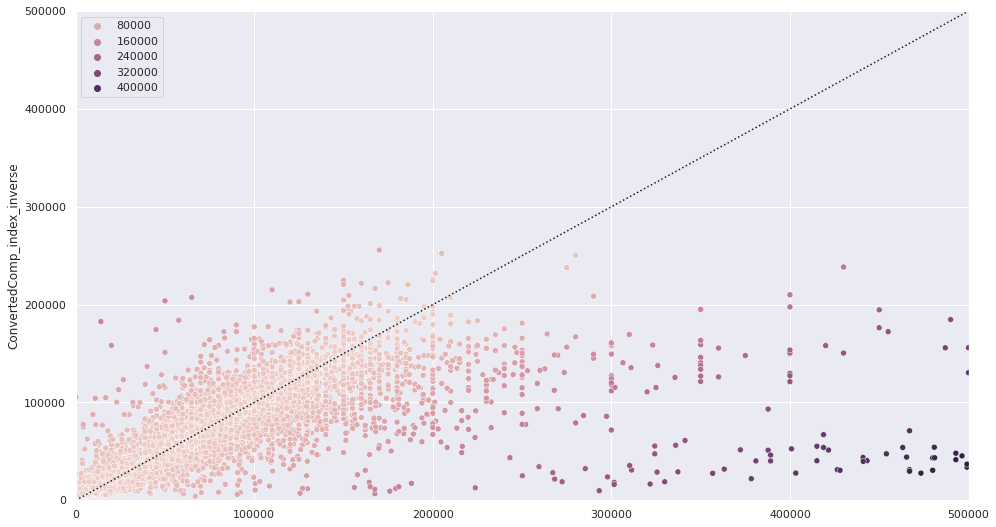

In [64]:
y_true_test = results.iloc[0, results.columns.get_loc("y_true_test")]
y_pred_test = results.iloc[0, results.columns.get_loc("y_pred_test")]

ax = sns.scatterplot( x=y_true_test, y=y_pred_test, hue=np.abs(y_true_test-y_pred_test) )
ax.set(ylim=(0, 500000))
ax.set(xlim=(0, 500000))
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, ':k')
plt.show()

In [65]:
experiment_list.sort_values("mape_test")

,mean_absolute_error_train,mape_train,mean_absolute_error_test,mape_test,index,num_feat,model_object,features,residuals,feature_importances
With Agg Features,21109.056117,0.922463,21967.291106,0.502809,LinearSVR,403,"LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_i...","Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
With Agg Features + relevant tech groups,21291.843768,0.926236,22186.115102,0.508523,LinearSVR,426,"LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_i...","Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
Initial Run w/o binning,20518.347348,0.953533,21579.776470,0.518055,SVR,577,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...","Index(['Age', 'Age1stCode', 'YearsCode', 'Year...",value abs_error abs_prc_error ...,None
Initial Run,20633.479500,0.941151,21800.019555,0.523697,LinearSVR,613,"LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_i...","Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...,None
"Initial Run w/o target transformation, binning",27396.074117,1.103052,28007.289962,0.803442,LinearSVR,577,"LinearSVR(C=10, dual=True, epsilon=0.0, fit_in...","Index(['Age', 'Age1stCode', 'YearsCode', 'Year...",value abs_error abs_prc_error ...,None


In [66]:
results = run(name="Initial Run + Feat Selection", feture_elimination_num_feat="auto", transform_target=True,
              columns_to_bin=["Age1stCode", "Age", "YearsCodePro", "YearsCode"])
results

Initial Run + Feat Selection
Target Transformed


,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,below_15_prc_mape_ratio,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test,features,residuals,feature_importances
RFE,0.880616,21906.407782,462043.133201,0.472221,0.533171,0.336372,22639.653445,467427.237625,0.456341,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",157,813 91000.0 21612 52942.0 10322 48...,813 119057.078376 21612 56309.445903 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...,None
RFE,0.845201,21641.490277,465684.244085,0.480488,0.534789,0.335405,22579.857267,469131.411324,0.461693,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",309,813 91000.0 21612 52942.0 10322 48...,813 134151.326762 21612 56228.263370 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...,None
RFE,0.845317,21626.863181,466335.774803,0.481312,0.538779,0.335682,22597.221834,469432.076269,0.460867,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",461,813 91000.0 21612 52942.0 10322 48...,813 134169.477724 21612 58252.571031 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...,None
RFE,0.845338,21625.527200,466280.069677,0.481341,0.538805,0.336234,22597.683422,469410.301768,0.460828,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",613,813 91000.0 21612 52942.0 10322 48...,813 134150.867995 21612 58293.513295 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...,None
RFE,0.985355,25476.327788,456103.739438,0.377246,0.643661,0.282498,26332.564612,457524.894923,0.362393,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",5,813 91000.0 21612 52942.0 10322 48...,813 126314.034147 21612 73909.212153 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...,None


In [67]:
results = run(exclude_columns=None, name="With Agg Features + Feat Selection",
              feat_agg_calculate_chosen_options_ratio=True,
             feat_agg_worked_with_high_and_low_leverage=True,
              feat_agg_worked_with_relevant_tech=False,
             feture_elimination_num_feat="auto",
             columns_to_bin=["Age1stCode", "Age", "YearsCodePro", "YearsCode"],
             transform_target=True)
results

With Agg Features + Feat Selection
Target Transformed


,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,below_15_prc_mape_ratio,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test,features,residuals,feature_importances
RFE,0.886552,21855.198985,461770.748814,0.474586,0.514040,0.341760,22557.151692,466855.219454,0.458681,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",403,813 91000.0 21612 52942.0 10322 48...,813 115794.001431 21612 56885.245897 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
RFE,0.886552,21855.198985,461770.748814,0.474586,0.514040,0.341760,22557.151692,466855.219454,0.458681,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",303,813 91000.0 21612 52942.0 10322 48...,813 115794.001431 21612 56885.245898 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
RFE,0.887289,21887.880313,462309.884368,0.474264,0.515635,0.336511,22594.973313,466217.901729,0.458105,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",204,813 91000.0 21612 52942.0 10322 48...,813 118494.827877 21612 56536.737981 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
RFE,0.907662,22086.599581,459587.976496,0.466682,0.527903,0.339550,22755.880438,468453.967987,0.450424,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",104,813 91000.0 21612 52942.0 10322 48...,813 113963.681823 21612 59843.255063 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
RFE,1.028626,24962.036512,451102.241509,0.390828,0.623797,0.288714,25629.572055,456338.691383,0.380880,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",5,813 91000.0 21612 52942.0 10322 48...,813 133188.604784 21612 71571.885535 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None


In [68]:
results = run(exclude_columns=None, name="With Agg Features + relevant tech groups + Feat Selection",
              feat_agg_calculate_chosen_options_ratio=True,
             feat_agg_worked_with_high_and_low_leverage=True,
              feat_agg_worked_with_relevant_tech=True,
             feture_elimination_num_feat="auto",
              columns_to_bin=["Age1stCode", "Age", "YearsCodePro", "YearsCode"],
             transform_target=True)
results

With Agg Features + relevant tech groups + Feat Selection
Target Transformed


,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,below_15_prc_mape_ratio,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test,features,residuals,feature_importances
RFE,0.890319,21791.903983,462766.318123,0.475985,0.522930,0.339412,22594.936308,467170.006557,0.458970,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",320,813 91000.0 21612 52942.0 10322 48...,813 108767.647992 21612 57834.021403 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
RFE,0.890319,21791.903983,462766.318123,0.475985,0.522930,0.339412,22594.936308,467170.006557,0.458970,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",426,813 91000.0 21612 52942.0 10322 48...,813 108767.647992 21612 57834.021403 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
RFE,0.890985,21809.451787,462261.106331,0.475508,0.523745,0.338030,22614.801395,466223.423284,0.459063,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",215,813 91000.0 21612 52942.0 10322 48...,813 110845.745669 21612 56740.754542 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
RFE,0.913488,22095.835679,460249.528932,0.466531,0.534078,0.338306,22749.482043,469046.743986,0.451427,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",110,813 91000.0 21612 52942.0 10322 48...,813 110846.897901 21612 56993.859488 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
RFE,1.029726,25086.640661,448708.714089,0.384985,0.629570,0.288990,25590.052424,456761.252371,0.379419,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",5,813 91000.0 21612 52942.0 10322 48...,813 124229.409834 21612 64956.366650 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None


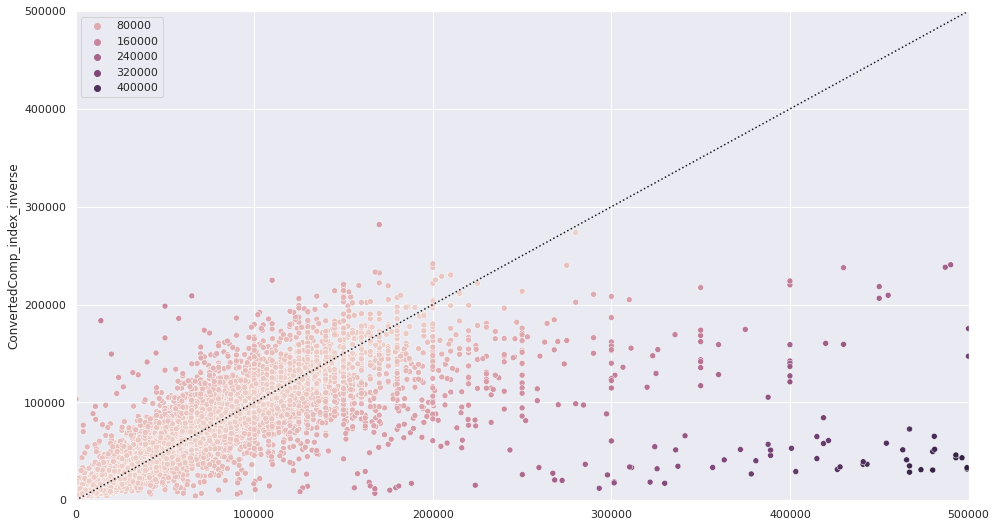

In [69]:
y_true_test = results.iloc[0, results.columns.get_loc("y_true_test")]
y_pred_test = results.iloc[0, results.columns.get_loc("y_pred_test")]

ax = sns.scatterplot( x=y_true_test, y=y_pred_test, hue=np.abs(y_true_test-y_pred_test) )
ax.set(ylim=(0, 500000))
ax.set(xlim=(0, 500000))
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, ':k')

plt.show()

In [70]:
experiment_list.sort_values("mape_test")

,mean_absolute_error_train,mape_train,mean_absolute_error_test,mape_test,index,num_feat,model_object,features,residuals,feature_importances
With Agg Features,21109.056117,0.922463,21967.291106,0.502809,LinearSVR,403,"LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_i...","Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
With Agg Features + relevant tech groups,21291.843768,0.926236,22186.115102,0.508523,LinearSVR,426,"LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_i...","Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
With Agg Features + Feat Selection,21855.198985,0.886552,22557.151692,0.514040,RFE,403,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...","Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
Initial Run w/o binning,20518.347348,0.953533,21579.776470,0.518055,SVR,577,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...","Index(['Age', 'Age1stCode', 'YearsCode', 'Year...",value abs_error abs_prc_error ...,None
With Agg Features + relevant tech groups + Feat Selection,21791.903983,0.890319,22594.936308,0.522930,RFE,320,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...","Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
Initial Run,20633.479500,0.941151,21800.019555,0.523697,LinearSVR,613,"LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_i...","Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...,None
Initial Run + Feat Selection,21906.407782,0.880616,22639.653445,0.533171,RFE,157,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...","Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...,None
"Initial Run w/o target transformation, binning",27396.074117,1.103052,28007.289962,0.803442,LinearSVR,577,"LinearSVR(C=10, dual=True, epsilon=0.0, fit_in...","Index(['Age', 'Age1stCode', 'YearsCode', 'Year...",value abs_error abs_prc_error ...,None


In [85]:
results.sort_values("mape_test")

,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,below_15_prc_mape_ratio,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test,features,residuals,feature_importances
RFE,0.890319,21791.903983,462766.318123,0.475985,0.522930,0.339412,22594.936308,467170.006557,0.458970,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",320,813 91000.0 21612 52942.0 10322 48...,813 108767.647992 21612 57834.021403 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
RFE,0.890319,21791.903983,462766.318123,0.475985,0.522930,0.339412,22594.936308,467170.006557,0.458970,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",426,813 91000.0 21612 52942.0 10322 48...,813 108767.647992 21612 57834.021403 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
RFE,0.890985,21809.451787,462261.106331,0.475508,0.523745,0.338030,22614.801395,466223.423284,0.459063,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",215,813 91000.0 21612 52942.0 10322 48...,813 110845.745669 21612 56740.754542 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
RFE,0.913488,22095.835679,460249.528932,0.466531,0.534078,0.338306,22749.482043,469046.743986,0.451427,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",110,813 91000.0 21612 52942.0 10322 48...,813 110846.897901 21612 56993.859488 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None
RFE,1.029726,25086.640661,448708.714089,0.384985,0.629570,0.288990,25590.052424,456761.252371,0.379419,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",5,813 91000.0 21612 52942.0 10322 48...,813 124229.409834 21612 64956.366650 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...,None


In [110]:
lower_boundry = train_set.ConvertedComp_index.describe()["25%"]
upper_boundry = train_set.ConvertedComp_index.describe()["75%"]
lower_boundry, upper_boundry

(1.8573268966416738, 2.134698573897456)

In [103]:
train_set = pd.concat([x_train, y_train], axis=1)

In [122]:
a = (train_set[train_set.ConvertedComp_index >= upper_boundry].describe().T["mean"]
    - train_set[train_set.ConvertedComp_index <= lower_boundry].describe().T["mean"])

In [113]:
train_set[train_set.ConvertedComp_index >= upper_boundry].ConvertedComp_index.mean()

2.31284832103573

In [123]:
a.sort_values(ascending=False)

YearsCode                                                                                           9.267846
YearsCodePro                                                                                        8.183482
Age                                                                                                 7.802686
ConvertedComp_index                                                                                 0.653975
NEWDevOps_Yes                                                                                       0.204583
OpSys_MacOS                                                                                         0.183058
NEWDevOpsImpt_Extremely important                                                                   0.158291
NEWPurchaseResearch_Start a free trial                                                              0.147831
NEWPurchaseResearch_Ask developers I know/work with                                                 0.133797
EdLevel_Master’s de